# Sinograms to Brain Images

c:\aml_ta\python_codes\exercises\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Loss in iteration 0 of 500: 46.589
Loss in iteration 25 of 500: 43.164
Loss in iteration 50 of 500: 38.496
Loss in iteration 75 of 500: 34.145
Loss in iteration 100 of 500: 30.198
Loss in iteration 125 of 500: 26.636
Loss in iteration 150 of 500: 23.437
Loss in iteration 175 of 500: 20.575
Loss in iteration 200 of 500: 18.026
Loss in iteration 225 of 500: 15.764
Loss in iteration 250 of 500: 13.766
Loss in iteration 275 of 500: 12.008
Loss in iteration 300 of 500: 10.469
Loss in iteration 325 of 500: 9.128
Loss in iteration 350 of 500: 7.965
Loss in iteration 375 of 500: 6.962
Loss in iteration 400 of 500: 6.102
Loss in iteration 425 of 500: 5.369
Loss in iteration 450 of 500: 4.748
Loss in iteration 475 of 500: 4.226


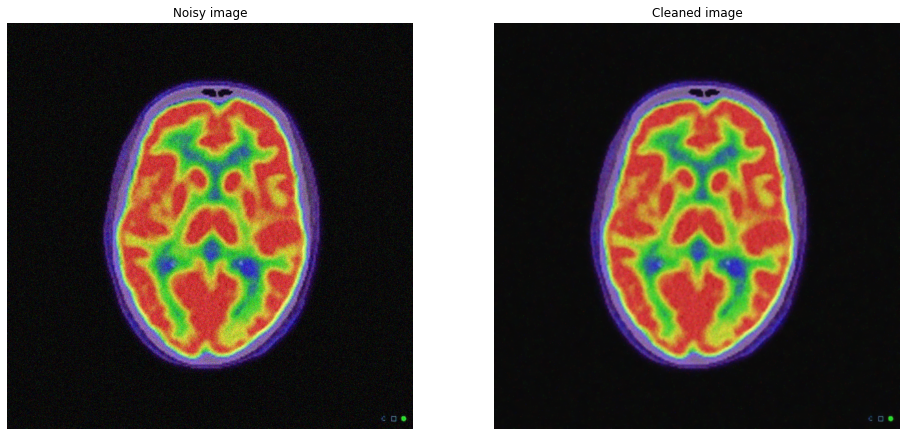

In [27]:
import kornia
import cv2
import numpy as np
import torch

import matplotlib.pyplot as plt

# read the image with OpenCV
img: np.ndarray = cv2.imread('pet.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0
img = img + np.random.normal(loc=0.0, scale=0.1, size=img.shape)
img = np.clip(img, 0.0, 1.0)

# convert to torch tensor
noisy_image: torch.tensor = kornia.image_to_tensor(img).squeeze()  # CxHxW


# define the total variation denoising network
class TVDenoise(torch.nn.Module):
    def __init__(self, noisy_image):
        super(TVDenoise, self).__init__()
        self.l2_term = torch.nn.MSELoss(reduction='mean')
        self.regularization_term = kornia.losses.TotalVariation()
        # create the variable which will be optimized to produce the noise free image
        self.clean_image = torch.nn.Parameter(data=noisy_image.clone(), requires_grad=True)
        self.noisy_image = noisy_image

    def forward(self):
        return self.l2_term(self.clean_image, self.noisy_image) + 0.0001 * self.regularization_term(self.clean_image)

    def get_clean_image(self):
        return self.clean_image

tv_denoiser = TVDenoise(noisy_image)

# define the optimizer to optimize the 1 parameter of tv_denoiser
optimizer = torch.optim.SGD(tv_denoiser.parameters(), lr=0.1, momentum=0.9)

# run the optimization loop
num_iters = 500
for i in range(num_iters):
    optimizer.zero_grad()
    loss = tv_denoiser()
    if i % 25 == 0:
        print("Loss in iteration {} of {}: {:.3f}".format(i, num_iters, loss.item()))
    loss.backward()
    optimizer.step()

# convert back to numpy
img_clean: np.ndarray = kornia.tensor_to_image(tv_denoiser.get_clean_image())

# Create the plot
fig, axs = plt.subplots(1, 2, figsize=(16, 10))
axs = axs.ravel()

axs[0].axis('off')
axs[0].set_title('Noisy image')
axs[0].imshow(img)

axs[1].axis('off')
axs[1].set_title('Cleaned image')
axs[1].imshow(img_clean)

plt.show()

c:\aml_ta\python_codes\exercises\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(410, 410)


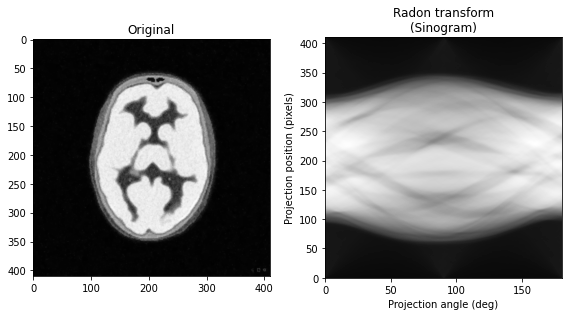

In [40]:
import kornia
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, rescale
from PIL import Image as im

img = img_clean[:,:,0]
image = rescale(img, scale=0.4, mode='reflect')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))

ax1.set_title("Original")
ax1.imshow(image, cmap=plt.cm.Greys_r)

theta = np.linspace(0., 180., max(image.shape), endpoint=False)
sinogram = radon(image, theta=theta)
print(sinogram.shape)
dx, dy = 0.5 * 180.0 / max(image.shape), 0.5 / sinogram.shape[0]
ax2.set_title("Radon transform\n(Sinogram)")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.imshow(sinogram, cmap=plt.cm.Greys_r,
           extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
           aspect='auto')

fig.tight_layout()
plt.show()

c:\aml_ta\python_codes\exercises\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(410, 410)
SART (1 iteration) rms reconstruction error: 0.0336
SART (2 iterations) rms reconstruction error: 0.0339


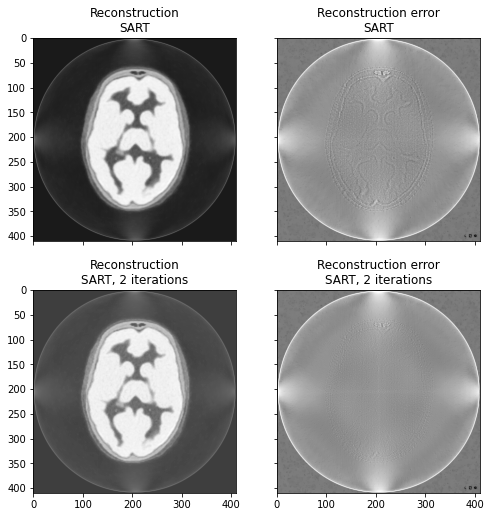

In [41]:
from skimage.transform import iradon_sart

reconstruction_sart = iradon_sart(sinogram, theta=theta)
print(reconstruction_sart.shape)
error = reconstruction_sart - image
print("SART (1 iteration) rms reconstruction error: "
      f"{np.sqrt(np.mean(error**2)):.3g}")

imkwargs = dict(vmin=-0.2, vmax=0.2)
fig, axes = plt.subplots(2, 2, figsize=(8, 8.5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].set_title("Reconstruction\nSART")
ax[0].imshow(reconstruction_sart, cmap=plt.cm.Greys_r)

ax[1].set_title("Reconstruction error\nSART")
ax[1].imshow(reconstruction_sart - image, cmap=plt.cm.Greys_r, **imkwargs)

# Run a second iteration of SART by supplying the reconstruction
# from the first iteration as an initial estimate
reconstruction_sart2 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart)
error = reconstruction_sart2 - image
print("SART (2 iterations) rms reconstruction error: "
      f"{np.sqrt(np.mean(error**2)):.3g}")

ax[2].set_title("Reconstruction\nSART, 2 iterations")
ax[2].imshow(reconstruction_sart2, cmap=plt.cm.Greys_r)

ax[3].set_title("Reconstruction error\nSART, 2 iterations")
ax[3].imshow(reconstruction_sart2 - image, cmap=plt.cm.Greys_r, **imkwargs)
plt.show()